# Lecture 3 - Multi-layer Artificial Neural Network 

### Overview

- [Modeling complex functions with artificial neural networks](#Modeling-complex-functions-with-artificial-neural-networks)
  - [Single-layer neural network recap](#Single-layer-neural-network-recap)
  - [Introducing the multi-layer neural network architecture](#Introducing-the-multi-layer-neural-network-architecture)
  - [Activating a neural network via forward propagation](#Activating-a-neural-network-via-forward-propagation)
- [Classifying handwritten digits](#Classifying-handwritten-digits)
  - [Obtaining the MNIST dataset](#Obtaining-the-MNIST-dataset)
  - [Implementing a multi-layer perceptron](#Implementing-a-multi-layer-perceptron)
  - [Coding the neural network training loop](#Coding-the-neural-network-training-loop)
  - [Evaluating the neural network performance](#Evaluating-the-neural-network-performance)
- [Training an artificial neural network](#Training-an-artificial-neural-network)
  - [Computing the loss function](#Computing-the-loss-function)
  - [Developing your intuition for backpropagation](#Developing-your-intuition-for-backpropagation)
  - [Training neural networks via backpropagation](#Training-neural-networks-via-backpropagation)
- [Convergence in neural networks](#Convergence-in-neural-networks)

<br>
<br>

In [11]:
from IPython.display import Image
%matplotlib inline

# Modeling complex functions with artificial neural networks

In Lecture 1, we looked at the concept of artificial neuron. Artificial neurons represent the building blocks of the multilayer artificial neural networks (NNs).

## Single-layer neural network recap

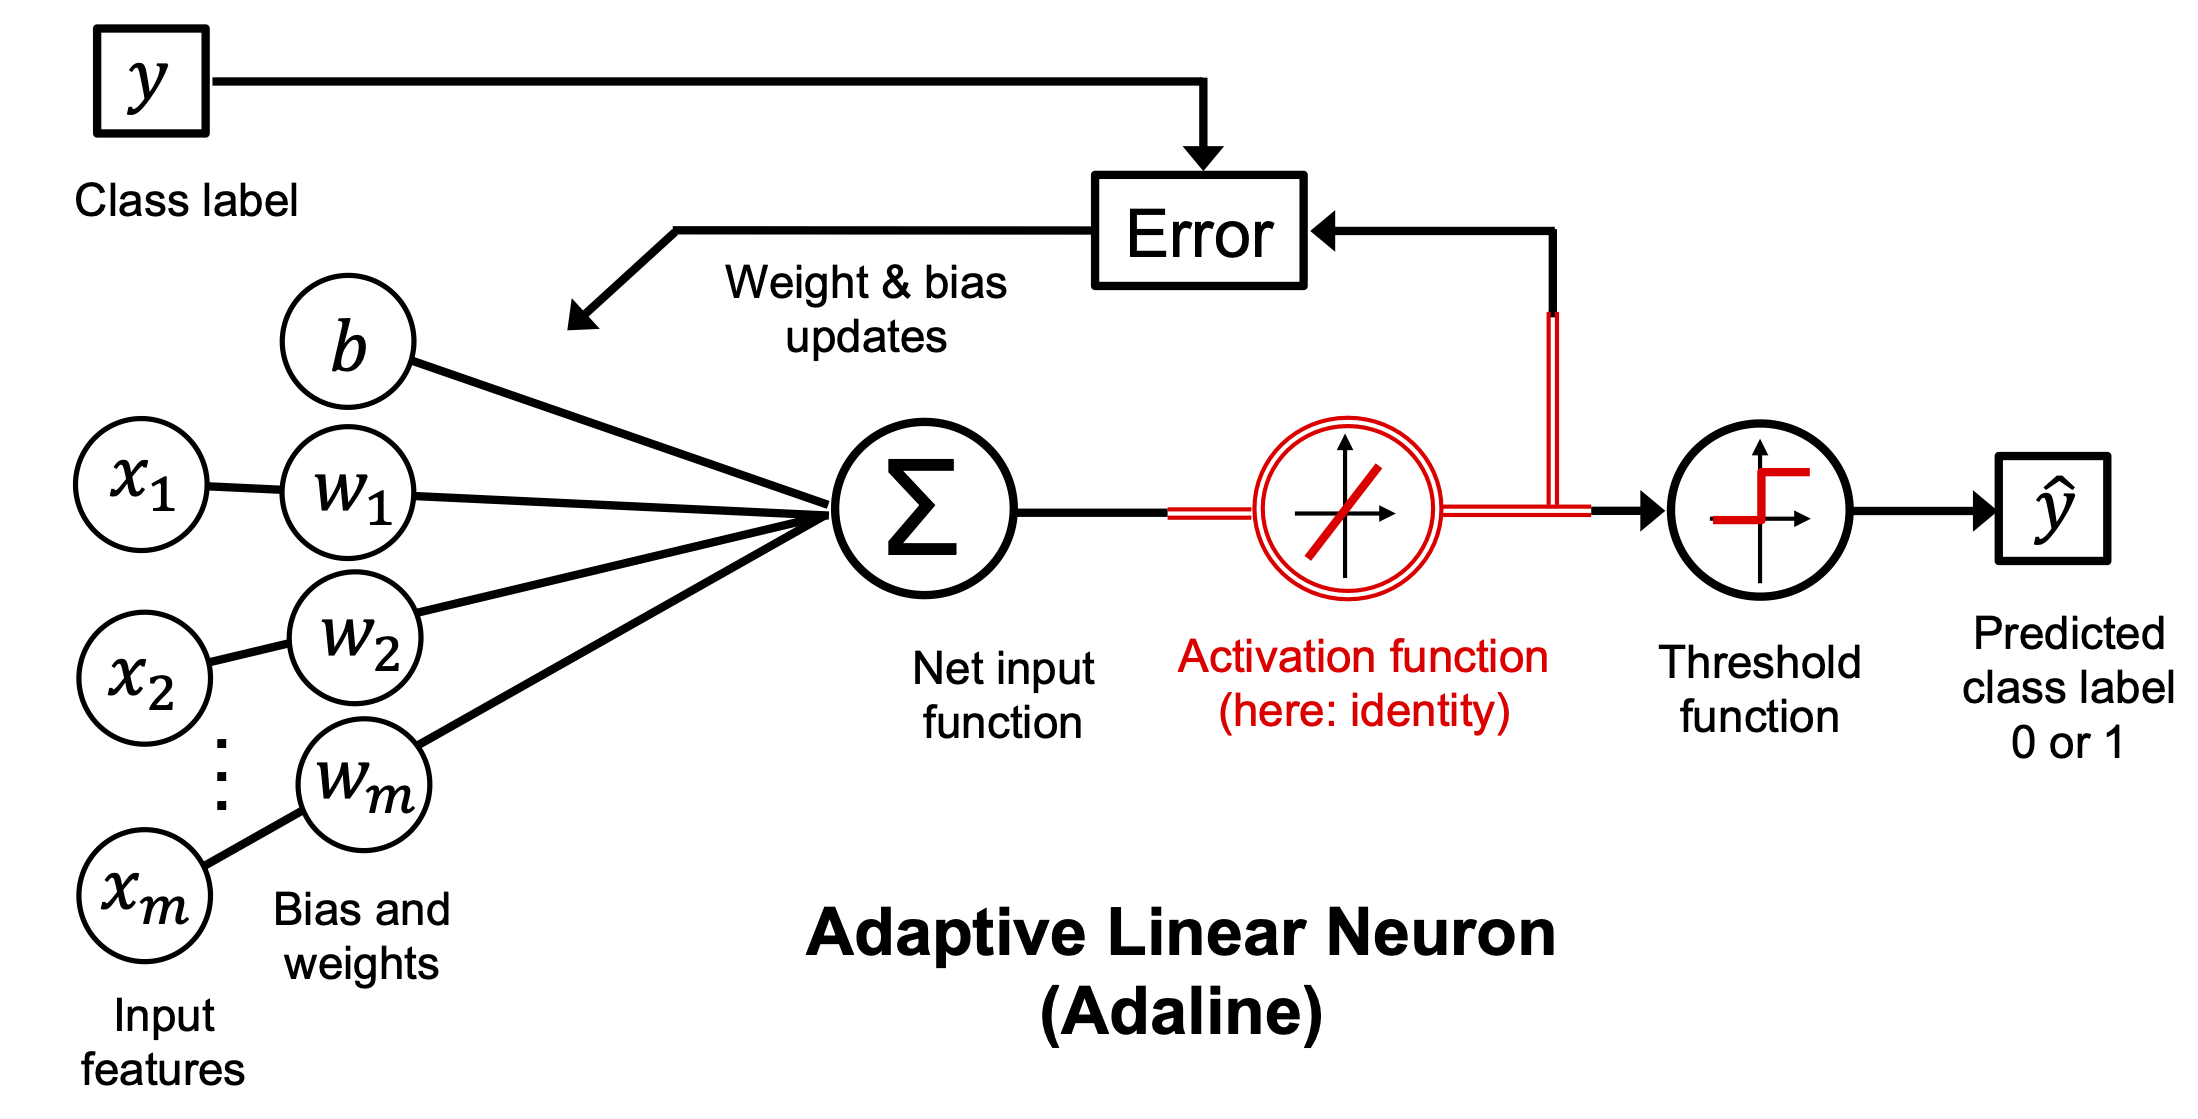

In [12]:
Image(filename='figures/11_01.png', width=600) 

Let us briefly recall some of the concepts of single-layer NNs that were introduced in Lecture 1, namely, the ADAptive LInear NEuron (Adaline) algorithm.

We implemented the Adaline algorithm to perform binary classification and used the
gradient descent optimization algorithm to learn the weight coefficients. In every epoch
(pass over the training dataset), we updated the weight vector $\mathbf{w}$ and bias unit $b$ using the following update rule:
\begin{equation}
\mathbf{w} := \mathbf{w} + \Delta \mathbf{w}, b := b + \Delta b,
\end{equation}
where $\Delta w_j = -\eta \frac{\partial L}{\partial w_j}$ and $\Delta b = -\eta \frac{\partial L}{\partial b}$ and $L$ is the loss function, **mean of squared errors (MSE)**. In other words, we computed the gradient based on the whole training dataset and updated the weights of the model by taking a step in the opposite direction of the loss gradient $\nabla L.$ 

Furthermore, we multiplied the gradient by a factor, the learning rate $\eta$ , which we had to choose carefully to balance the speed of learning against the risk of overshooting the global minimum of the loss function.

In gradient descent optimization, we updated all weights simultaneously after each epoch, and we
defined the partial derivative for each weight $w_j$ in the weight vector $\mathbf{w}$ as follows:
\begin{equation}
\frac{\partial L}{\partial w_j} = \frac{\partial}{\partial w_j} \frac{1}{n}\sum_i \bigl(y^{(i)} - a^{(i)}\bigr)^2 = -\frac{2}{n}\sum_i\bigl(y^{(i)} - a^{(i)}\bigr)x_j^{(i)}.
\end{equation}
Here $y^{(i)}$ is the target class label of a particular example $x^{(i)},$ and $a^{(i)}$ is the activation of the neuron, which is a linear function in the special case of Adaline.

Furthermore, we defined the activation function $\sigma(\cdot)$ as follows:
\begin{equation}
\sigma(\cdot) = z = a.
\end{equation}

Here, the net input, $z$, is a linear combination of the weights that are connecting the input layer to the output layer:
\begin{equation}
z = \sum_j w_j x_j + b = \mathbf{w}^\top \mathbf{x} + b.
\end{equation}

While we used the activation $\sigma(\cdot)$ to compute the gradient update, we implemented a threshold function to squash the continuous-valued output into binary class labels for prediction:
\begin{equation}
\widehat{y} = \begin{cases} 
1 & \text{if } z \geq 0\\
0 & \text{otherwise}
\end{cases}
\end{equation}

We also learned about a certain trick to accelerate the model learning, the so-called **stochastic gradient descent (SGD)** optimization. SGD approximates the loss from a single training sample (online learning) or a small subset of training examples (mini-batch learning). We will make use of this concept later in this lecture when we implement and train a **multilayer perceptron (MLP)**. 

Apart from faster learning—due to the more frequent weight updates compared to gradient descent—its noisy nature is also regarded as beneficial when training multilayer NNs with nonlinear activation functions, which do not have a convex loss function. Here, the added noise can help to escape local loss minima.

## Introducing the multi-layer neural network architecture

In this section, we learn how to connect multiple single neurons to a multilayer feedforward NN. This special type of fully connected network is also called **multilayer perceptron (MLP)**.

Y: output, X:input, Y = F(X)

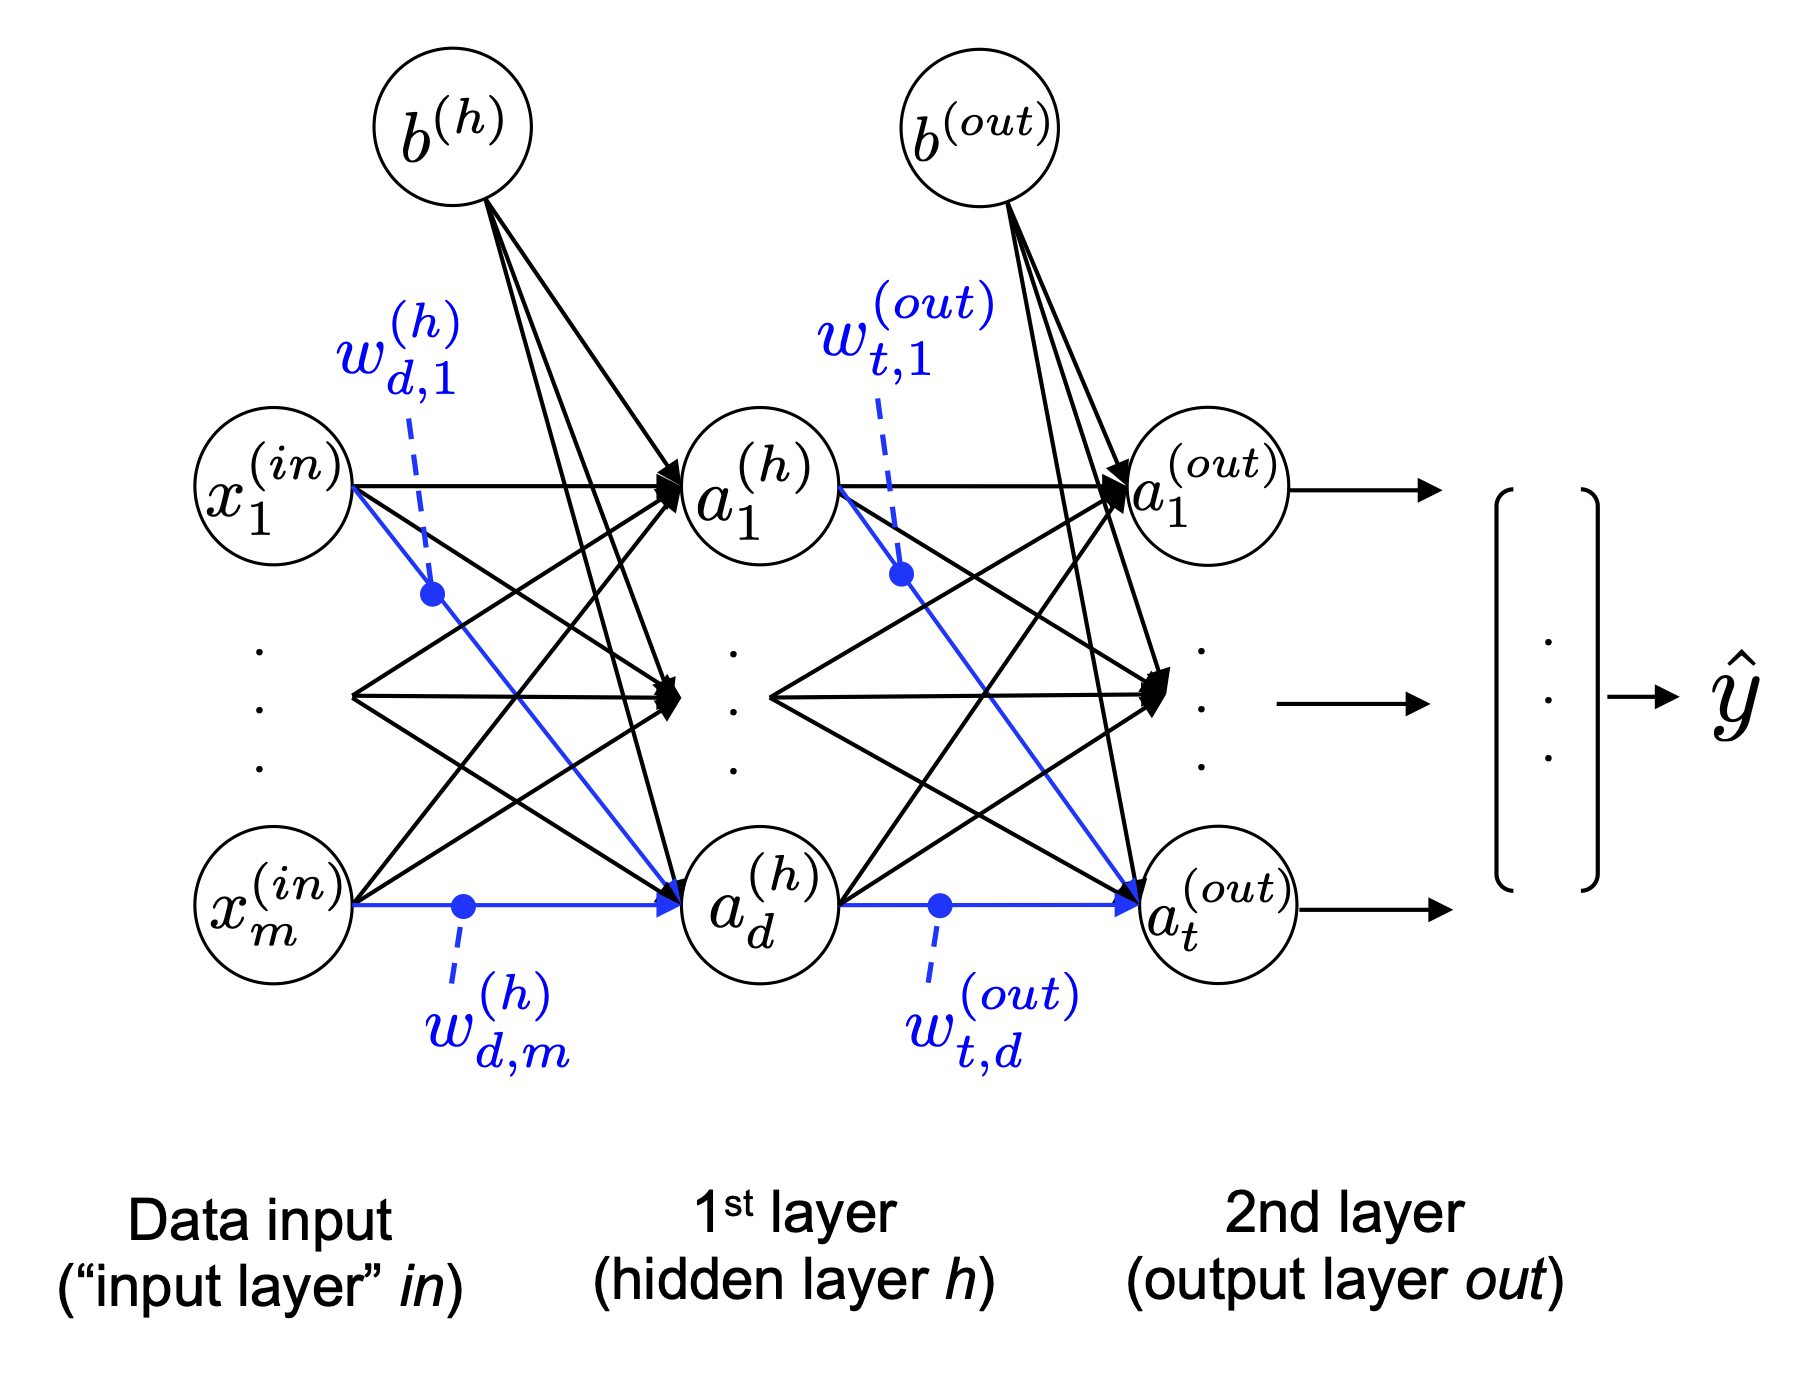

In [13]:
Image(filename='figures/11_02.png', width=600) 

Next to the data input, the MLP depicted above has one hidden layer and one output layer. The units in the hidden layer are fully connected to the input features, and the output layer is fully connected to the hidden layer. If such a network has more than one hidden layer, we also call it a
deep NN. 

Note that in some contexts, the inputs are also regarded as a layer. However, in this case,
it would make the Adaline model, which is a single-layer neural network, a two-layer neural network,
which may be counterintuitive.

We can add any number of hidden layers to the MLP to create deeper network architectures. Practically, we can think of the number of layers and units in an NN as additional hyperparameters
that we want to optimize for a given problem task using the cross-validation technique.

However, the loss gradients for updating the network’s parameters, which we will calculate later via **backpropagation**, will become increasingly small as more layers are added to a network. This vanishing gradient problem makes model learning more challenging. Therefore, special algorithms have been developed to help train such DNN structures; this is known as deep learning. We will discuss it in more detail later.

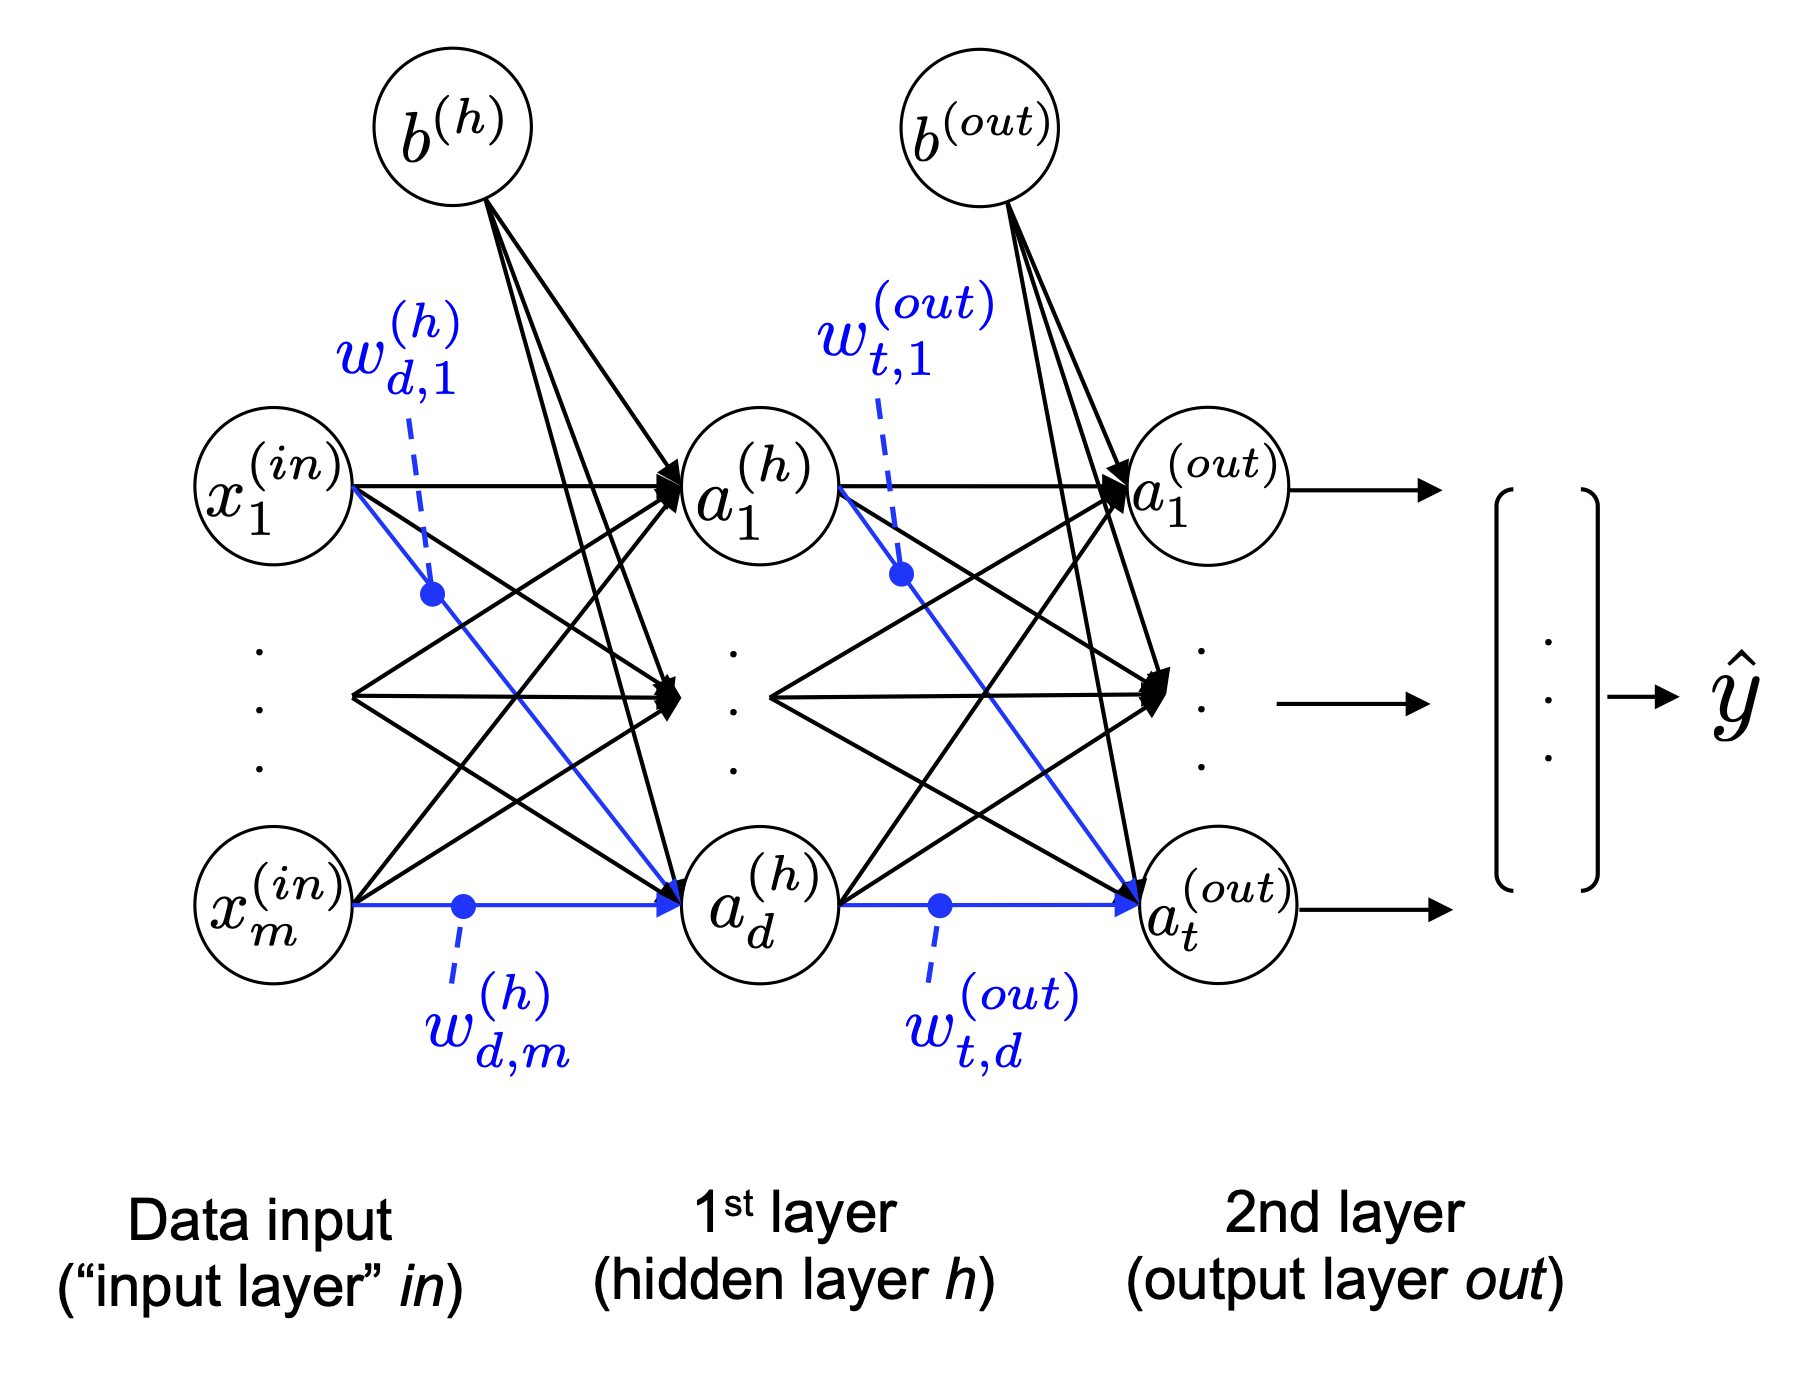

In [14]:
Image(filename='figures/11_02.png', width=600) 

We denote the $i$th activation unit in the $l$th layer as $a^{(l)}_i$. $x^{(in)}_i$ refers to the $i$th input feature value, $a^{(h)}_i$ refers to the $i$th unit in the hidden layer, and $a^{(out)}_i$ refers to the $i$th unit in the output layer. $\mathbf{b}^{(h)}$ and $\mathbf{b}^{(out)}$ are bias unit vectors with the number of elements being equal to the number of nodes in the layer they correspond to. For example, $\mathbf{b}^{(h)}$ stores $d$ bias units, where $d$ is the number of nodes in the hidden layer.

Each node in layer $l$ is connected to all nodes in layer $l + 1$ via a weight coefficient. For example, the connection between the $k$th unit in layer $l$ to the $j$th unit in layer $l + 1$ will be written as $w^{(l)}_{j,k.}$ We denote the weight matrix that connects the input to the hidden layer as $\mathbf{W}^{(h)}$, and we write the matrix that connects the hidden layer to the output layer as $\mathbf{W}^{(out)}.$

While one unit in the output layer would suffice for a binary classification task, we can perform multiclass classification via a generalization of the one-versus-all (OvA) technique. For example, we can encode the three class labels in the familiar Iris dataset (0=<tt>Setosa</tt>, 1=<tt>Versicolor</tt>, 2=<tt>Virginica</tt>) as follows:
\begin{equation}
0 = \begin{bmatrix}
1\\
0\\
0
\end{bmatrix}, 1 = \begin{bmatrix}
0\\
1\\
0
\end{bmatrix}, 2 = \begin{bmatrix}
0\\
0\\
1
\end{bmatrix}.
\end{equation}
This **one-hot vector representation** allows us to tackle classification tasks with an arbitrary number
of unique class labels present in the training dataset.

Thus, to summarize, the weights that connect the input and hidden layers are in a $d \times m$ dimensional matrix $\mathbf{W}^{(h)}$, where $d$ is the number of hidden units and $m$ is the number of input units.

## Activating a neural network via forward propagation

Next, we describe the process of **forward propagation** to calculate the output of an MLP model. Let us first summarize the MLP learning procedure in three simple steps:

1. Starting at the input layer, we forward propagate the patterns of the training data through the network to generate an output.

2. Based on the network’s output, we calculate the loss that we want to minimize using a loss function.

3. We backpropagate the loss, find its derivative with respect to each weight and bias unit in the network, and update the model.

Finally, after we repeat these three steps for multiple epochs and learn the weight and bias parameters of the MLP, we use forward propagation to calculate the network output and apply a  threshold function to obtain the predicted class labels in the one-hot representation.

### Details of forward propagation procedure

Since each unit in the hidden layer is connected to all units in the input layers, we first calculate the activation unit of the hidden layer $a^{(h)}_1$ as follows:
\begin{align}
z_1^{(h)} &= x_1^{(in)} w_{1,1}^{(h)} + x_2^{(in)} w_{1,2}^{(h)} + \ldots + x_m^{(in)} w_{1,m}^{(h)}\\ 
a_1^{(h)} &= \sigma(z_1^{(h)}).
\end{align}
Here, $z_1^{(h)}$ is the net input and $\sigma(\cdot)$ is the activation function, which has to be differentiable to learn the weights that connect the neurons using a gradient-based approach. 

To be able to solve complex problems, we need nonlinear activation functions in our MLP model. The sigmoid (logistic) activation function from the section about logistic regression is one such activation function.

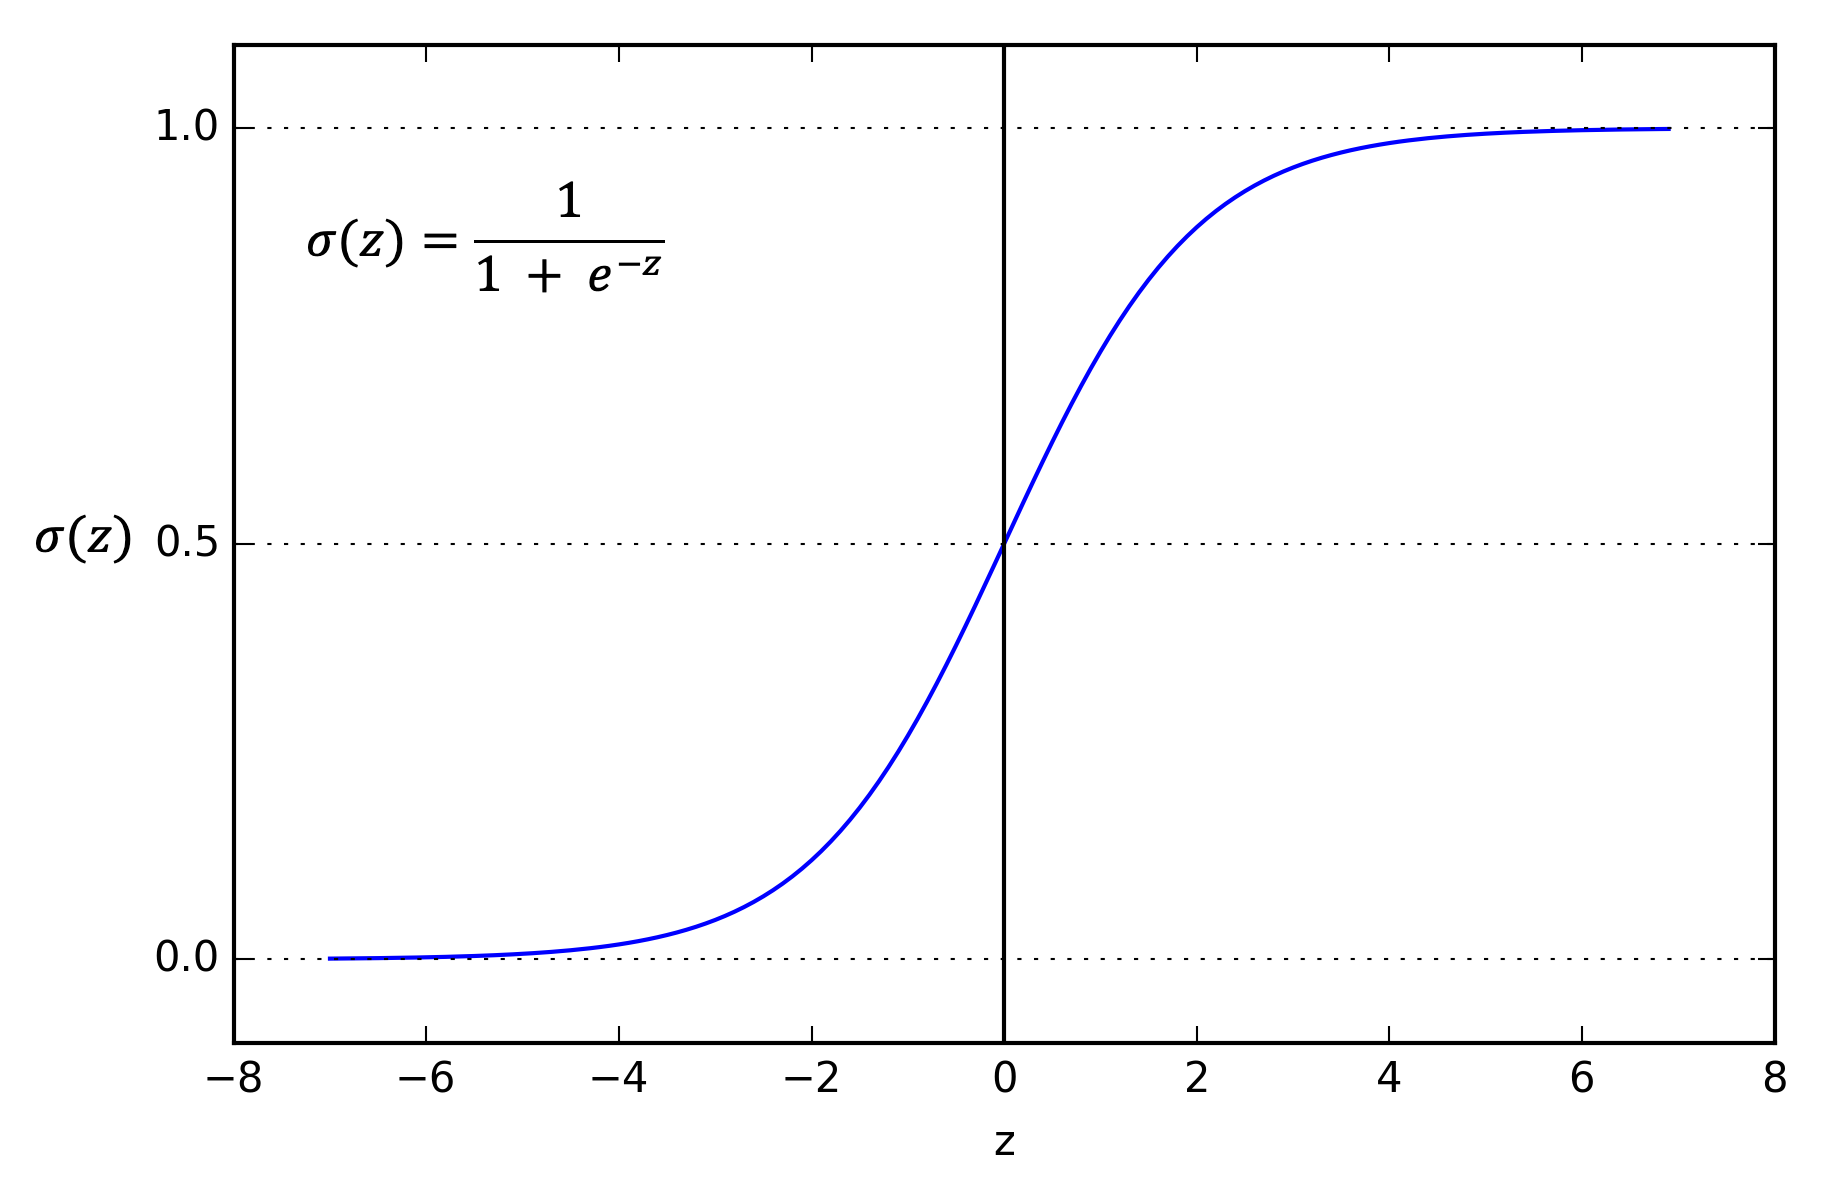

In [15]:
Image(filename='figures/11_03.png', width=500) 

MLP is a typical example of a feedforward artificial NN. The term **feedforward** refers to the fact that each layer serves as the input to the next layer without loops, in contrast to recurrent NNs—an architecture that we will discuss later in this course.

To make use of the matrix operations, we write the activation in a more compact form using the concepts of basic linear algebra, which will allow us to vectorize our code implementation via NumPy rather than writing multiple nested and computationally expensive Python <tt>for</tt> loops.
\begin{align}
z^{(h)} &= \mathbf{x}^{(in)} {\mathbf{W}^{(h)}}^\top + \mathbf{b}^{(h)}\\
a^{(h)} &= \sigma(z^{(h)}).
\end{align}
Here $x^{(h)}$ is $1 \times m$ dimensional feature vector. $\mathbf{W}^{(h)}$ is a $d \times m$ dimensional weight matrix where $d$ is the number of units in the hidden layer. The bias vector $\mathbf{b}^{(h)}$ consists of $d$ bias units.

After matrix-vector multiplication, we obtain the $1 \times d $ dimensional net input vector $z^{(h)}$ to calculate the activation $\mathbf{a}^{(h)}$. Furthermore, we can generalize this computation to all n examples in the training dataset:
\begin{equation}
\mathbf{Z}^{(h)} = \mathbf{X}^{(in)} {\mathbf{W}^{(h)}}^\top + \mathbf{b}^{(h)}.
\end{equation}
In the above, $\mathbf{X}^{(in)}$ is an $n\times m$ matrix, and the matrix multiplication will result in an $n \times d$ dimensional net input matrix $\mathbf{Z}^{(h)}.$ Finally, we apply the activation function $\sigma(\cdot)$ to each value in the net input matrix to get the $n \times d$ activation matrix in the next layer (here, the output layer):
\begin{equation}
\mathbf{A}^{(h)} = \sigma\bigl(\mathbf{Z}^{(h)}\bigr).
\end{equation}
Similarly, we can write the activation of the output layer in vectorized form for multiple examples:
\begin{equation}
\mathbf{Z}^{(out)} = \mathbf{A}^{(h)} {\mathbf{W}^{(out)}}^\top + \mathbf{b}^{(out)}.
\end{equation}
Here, we multiply the transpose of the $t \times d$ matrix $\mathbf{W}^{(out)}$ ($t$ is the number of output units) by the $n \times d$ dimensional matrix, $\mathbf{A}^{(h)},$ and add the $t$ dimensional bias vector $\mathbf{b}^{(out)}$ to obtain the $n \times t$ dimensional matrix $\mathbf{Z}^{(out)}.$ The columns in this matrix represent the outputs for each sample.

Lastly, we apply the sigmoid activation function to obtain the continuous-valued output of our network:
\begin{equation}
\mathbf{A}^{(out)} = \sigma\bigl(\mathbf{Z}^{(out)}\bigr).
\end{equation}
Similar to $\mathbf{Z}^{(out)},$ $\mathbf{A}^{(out)}$ is an $n \times t$ dimensional matrix.

# Classifying handwritten digits

Let us first implement and train our first multilayer NN to classify handwritten digits
from the popular Mixed National Institute of Standards and Technology (MNIST) dataset that has
been constructed by Yann LeCun and others and serves as a popular benchmark dataset for machine
learning algorithms.

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)

The MNIST dataset was constructed from two datasets of the US National Institute of Standards and
Technology (NIST). The training dataset consists of handwritten digits from 250 different people, 50
percent high school students, and 50 percent employees from the Census Bureau. Note that the test
dataset contains handwritten digits from different people following the same split.

In [2]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In <tt>scikit-learn</tt>, the <tt>fetch_openml</tt> function downloads the MNIST dataset from OpenML (https://www.openml.org/d/554) as <tt>pandas DataFrame</tt> and <tt>Series</tt> objects, which is why we use the <tt>.values</tt> attribute to obtain the underlying NumPy arrays.

The images in the MNIST dataset consist of $28 \times 28$ pixels, and each pixel is represented by a grayscale intensity value. Here, <tt>fetch_openml</tt> already unrolled the $28 \times 28$ pixels into one-dimensional row vectors, which represent the rows in our $X$ array (784 per row or image) above. The second array ($y$) returned by the <tt>fetch_openml</tt>function contains the corresponding target variable, the class labels (integers 0-9) of the handwritten digits.

Let us normalize the pixels values in MNIST to the range –1 to 1 (originally 0 to 255) via the following:

In [3]:
X = ((X / 255.) - 0.5) * 2

The reason behind this is that gradient-based optimization is much more stable under these conditions, as discussed in Lecture 1. Previously, we derived scaling parameters from the training dataset and used these to scale each column in the training dataset and test dataset. However, when working with image pixels, centering them at zero and rescaling them to a $[–1, 1]$ range is also common and usually works well in practice.

To get an idea of how those images in MNIST look, let us visualize examples of the digits 0-9 after reshaping the 784-pixel vectors from our feature matrix into the original $28 \times 28$ image that we can plot via Matplotlib’s <tt>imshow</tt> function:

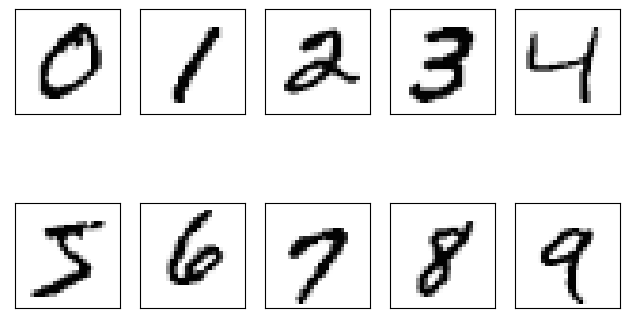

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In addition, let us also plot multiple examples of the same digit to see how different the handwriting for each really is:

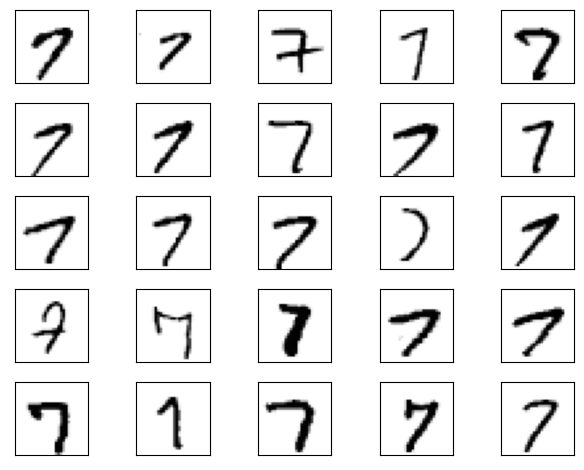

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Finally, let us divide the dataset into training, validation, and test subsets. The following code will split the dataset such that 55,000 images are used for training, 5,000 images for validation, and 10,000 images for testing:

In [6]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

## Implementing a multi-layer perceptron

To keep things simple, we will implement an MLP with only one hidden layer.

In [7]:
import numpy as np

In [8]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In the above, we implement the main class for our MLP, which we call <tt>NeuralNetMLP</tt>. There are three class methods,<tt>.\_\_init\_\_()</tt>, <tt>.forward()</tt>, and <tt>.backward()</tt>.

* The <tt>.\_\_init\_\_()</tt> constructor instantiates the weight matrices and bias vectors for the hidden and the output layer.
* The <tt>forward method</tt> takes in one or more training examples and returns the predictions. It returns both the activation values from the hidden layer and the output layer, <tt>a\_h</tt> and  <tt>a\_out</tt>. While <tt>a\_out</tt> represents the class-membership probabilities that we can convert to class labels, which we care about, we also need the activation values from the hidden layer, <tt>a\_h</tt>, to optimize the model parameters: the weight and bias units of the hidden and output layers.
* The <tt>backward method</tt>, which updates the weight and bias parameters of the neural network.
    * The <tt>backward method</tt> method implements the so-called *backpropagation* algorithm, which calculates the gradients of the loss with respect to the weight and bias parameters. Similar to Adaline, these gradients are then used to update these parameters via gradient descent. For  simplicity, the loss function this derivation is based on is the same MSE loss that we used in Adaline. Alternative loss functions, such as multi-category cross-entropy loss, which is a generalization of the binary logistic regression loss to multiple classes can be considered too.

After we have implemented the <tt>NeuralNetMLP</tt> class, we use the following code to instantiate a new <tt>NeuralNetMLP</tt> object. The hidden layer consists of 50 nodes.

In [32]:
model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

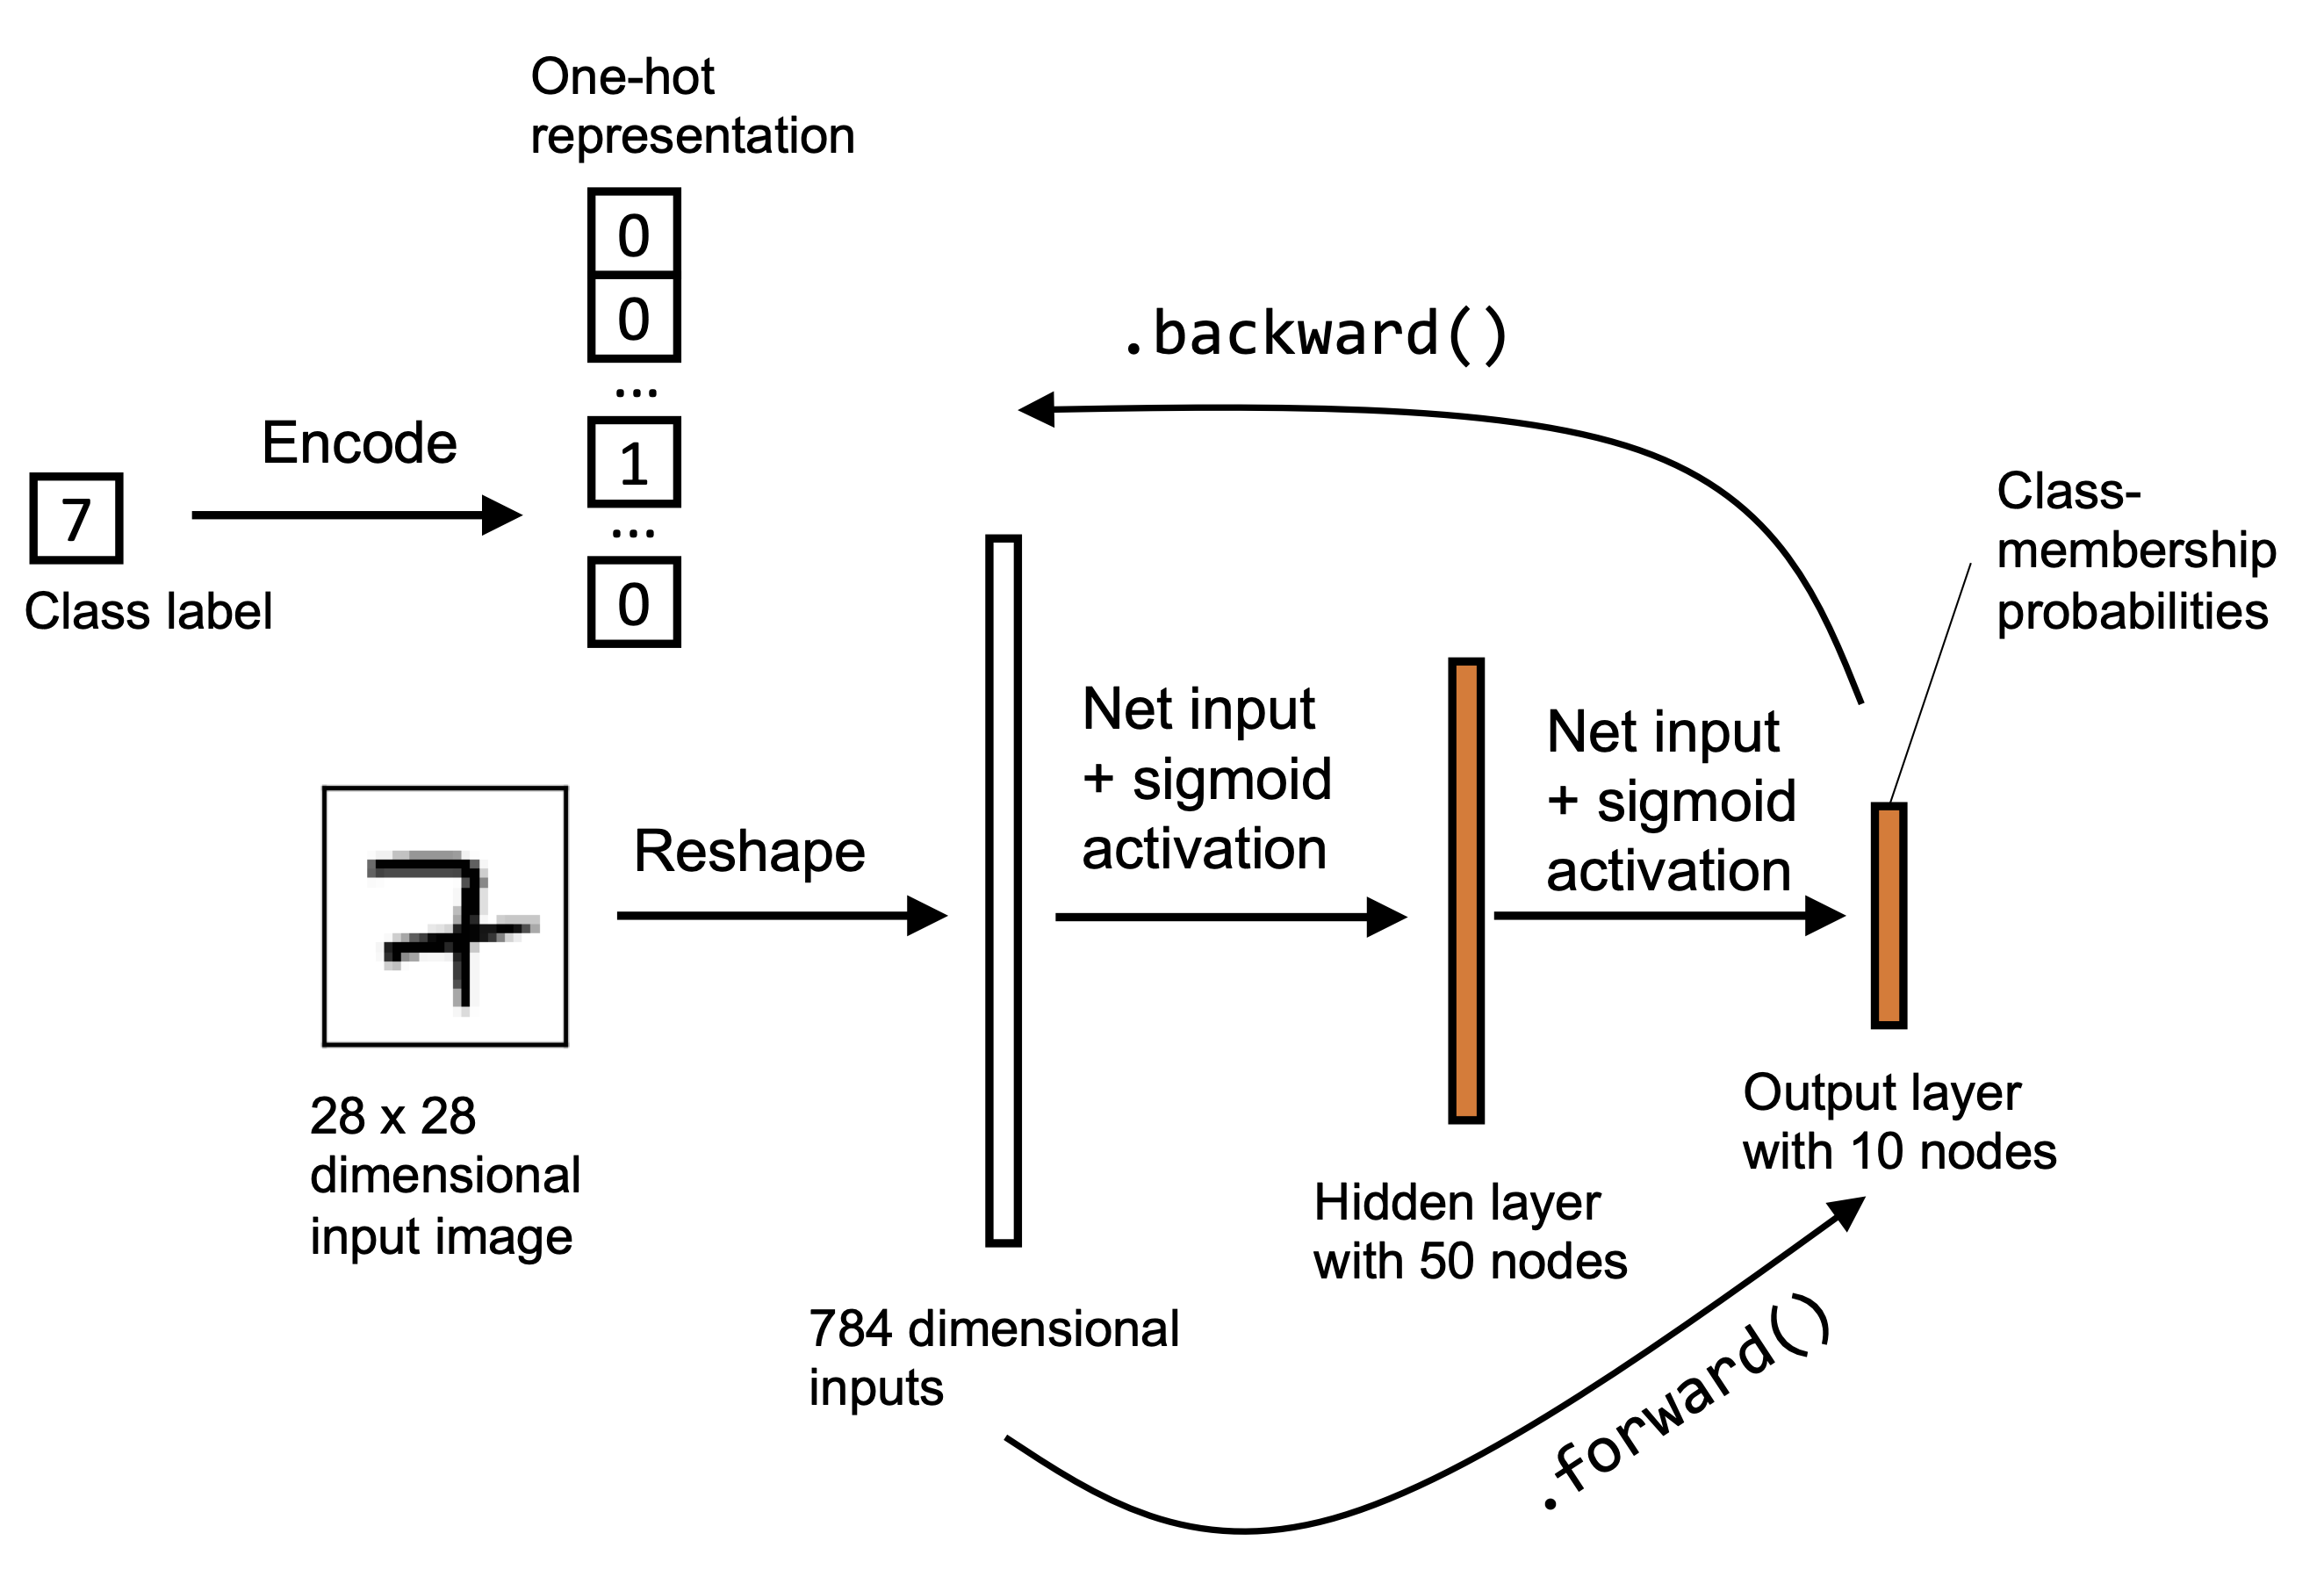

In [16]:
Image(filename='figures/11_06.png', width=500) 

## Coding the neural network training loop

The next step is to train the model. First, we will define some helper functions for data loading. Second, we will embed these functions into the training loop that iterates over the dataset in multiple epochs.

The first function we are going to define is a mini-batch generator, which takes in our dataset and divides it into mini-batches of a desired size for stochastic gradient descent training.

In [33]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


From the above output, we can confirm that the mini-batch generator works as intended and produces mini-batches of the desired size, that is 100.

Next we define the loss function and performance metric that we can use to monitor the
training process and evaluate the model. The MSE loss and accuracy function can be implemented
as follows:

In [34]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


The above code computes the initial validation set MSE and accuracy of the model. Note that <tt>model.forward()</tt> returns the hidden and output layer activations. 

Remember that we have 10 output nodes (one corresponding to each unique class label). Hence, when computing the MSE, we first converted the class labels into one-hot encoded class labels in the <tt>mse_loss()</tt> function. 

The output layer activations, since we used the logistic sigmoid function, are values in the range $[0, 1]$. For each input, the output layer produces 10 values in the range $[0, 1]$, so we used the <tt>np.argmax()</tt> function to select the index position of the largest value, which yields the predicted class label. 

We then compared the true labels with the predicted class labels to compute the accuracy via the <tt>accuracy()</tt> function we defined. As we can see from the preceding output, the accuracy is not very high. However, given that we have a balanced dataset with 10 classes, a prediction accuracy of approximately 10 percent is what we would expect for an untrained model producing random predictions.

The following function will compute the MSE and accuracy incrementally by iterating over the dataset one mini-batch at a time to be more memory-efficient:

In [35]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

Before we implement the training loop, let us test the function and compute the initial training set MSE and accuracy of the model we instantiated previouslt and make sure it works as intended.

In [36]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.4%


As we can see from the results, our generator approach produces the same results as the previously
defined MSE and accuracy functions.

Let us implement the code to train our model.

In [37]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

* The <tt>train()</tt> function iterates over multiple epochs, and in each epoch, it used the previously defined <tt>minibatch_generator()</tt> function to iterate over the whole training set in mini-batchesfor stochastic gradient descent training. 
* Inside the mini-batch generator for loop, we obtain the outputs from the model, <tt>a\_h</tt> and <tt>a\_out</tt>, via its <tt>.forward()</tt> method. 
* Then, we compute the loss gradients via the model’s <tt>.backward()</tt> method.
* Using the loss gradients, we update the weights by adding the negative gradient multiplied by the learning rate.

For example, to update the model weights of the hidden layer, we defined the following line: 
```json
model.weight_h -= learning_rate * d_loss__d_w_h
```
For a single weight $w_j,$ this corresponds to the following partial derivative-based update:
\begin{equation}
w_j:=w_j - \eta \frac{\partial L}{\partial w_j}.
\end{equation}
Finally, the last portion of the previous code computes the losses and prediction accuracies on the
training and test sets to track the training progress.

Let us now execute this function to train our model for 50 epochs.

In [38]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.80

In NN training, it is really useful to compare training and validation accuracy for judging whether the network model performs well, given the architecture and hyperparameters. If we observe a low training and validation accuracy, there is likely an issue with the training dataset, or the hyperparameters’ settings are not ideal.

In general, training (deep) NNs is relatively expensive compared to the other models, such as the linear classifiers, we’ve discussed so far. Thus, we may want to stop the training early in certain circumstances and start over with different hyperparameter settings. On the other hand, if we find that the NN increasingly overfits the training data (noticeable by an increasing gap between training and validation dataset performance), we may want to stop the training early, as well.

## Evaluating the neural network performance

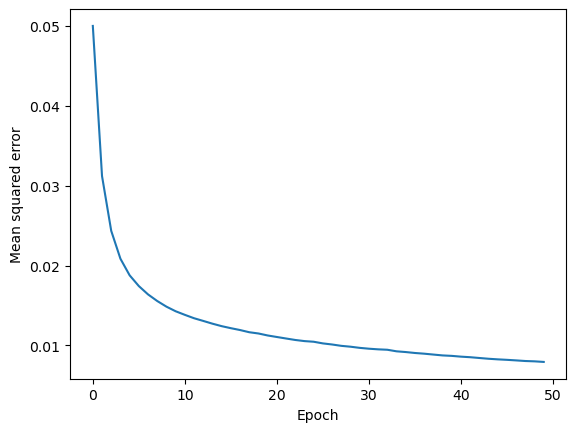

In [39]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

The loss decreased substantially during the first 10 epochs and seems to slowly converge in the last 10 epochs. However, the small slope between epoch 40 and epoch 50 indicates that the loss would further decrease with training over additional epochs.

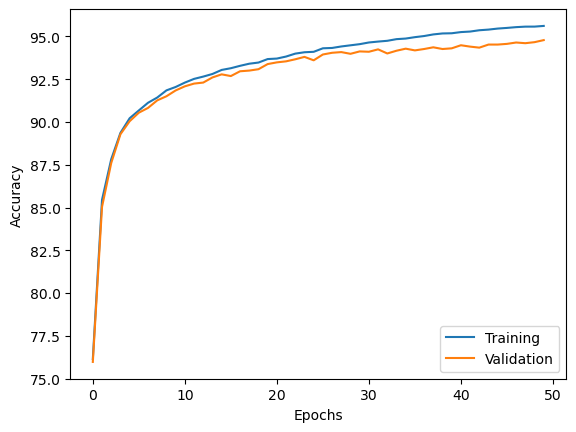

In [40]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

The above plot shows the training and validation accuracy over 50 epochs. The plot reveals that as we train more the gap between training and validation accuracy increases as the network starts to slightly overfit the training data.

Next, we evaluate the generalization performance of the model by calculating the prediction accuracy on the test dataset.

In [41]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.54%


We can see that the test accuracy is very close to the validation set accuracy corresponding to the last epoch (94.74%). Moreover, the respective training accuracy is only minimally higher at 95.59%, thus confirming that the model only slightly overfits the training data.

# Training an artificial neural network

In this part, we look at the computation of the loss function and the backpropagation algorithm which is used to learn the model parameters (weight vectors across different layers).

## Computing the loss function

We used the mean squared error (MSE) loss function to train the multilayer NN as it makes the derivation of the gradients a bit easier to follow. However, a more common choice of loss function for training NN classifiers is the *multi-category cross-entropy loss*.

MSE loss either has to sum or average over the *t* activation units in our network in addition to averaging over the n examples in the dataset or mini-batch. Thus, the MSE loss funciton is given as 
\begin{align}
L(\mathbf{W}, \mathbf{b}) = \frac{1}{n}\sum^n_{1}\frac{1}{t}\sum^t_{j=1} \bigl(y_j^{[i]} - a_j^{(out)[i]}\bigr)^2.
\end{align}

Here, again, the superscript $[i]$ is the index of a particular example in the training dataset.

Recall that our goal is to minimize the loss function $L(\mathbf{W}, \mathbf{b})$ for which we need to calculate the partial
derivative of the parameters $\mathbf{W}$ with respect to each weight in every layer of the network:

\begin{align}
\frac{\partial L(\mathbf{W}, \mathbf{b})}{\partial w^{(h)}_{j,l}}.
\end{align}

The backpropagation algorithm allows us to calculate those partial derivatives to minimize the loss function.

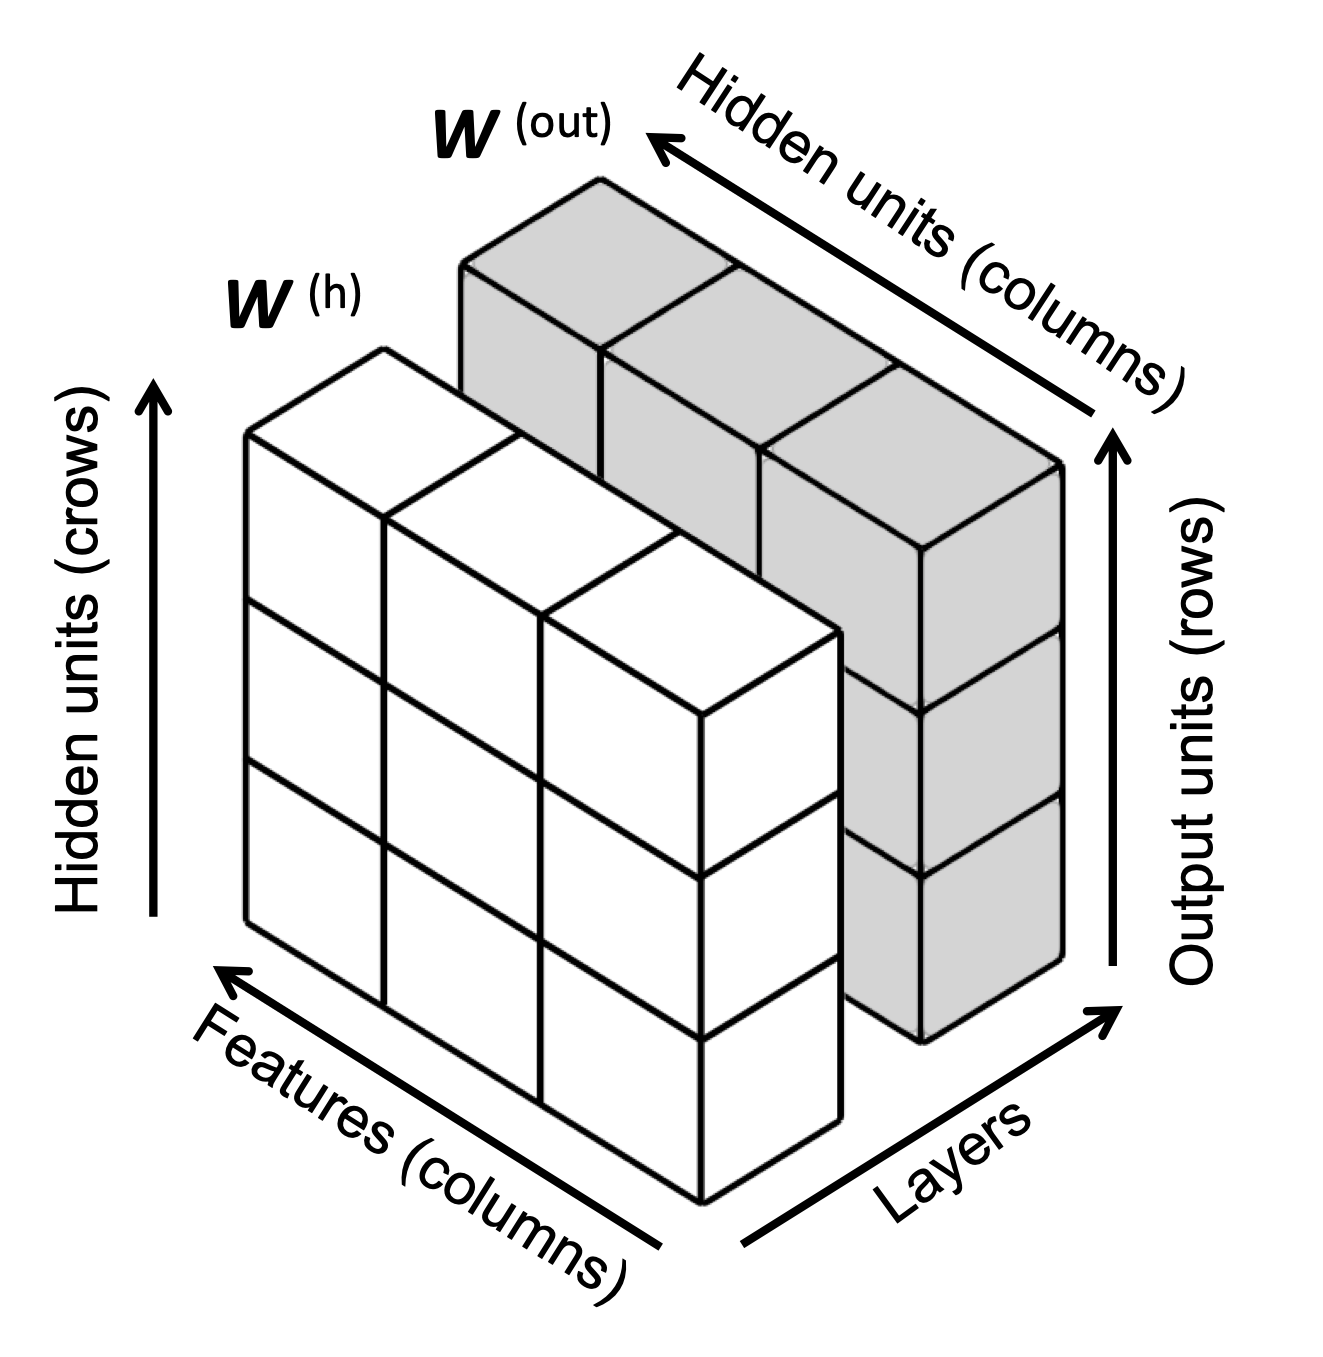

In [26]:
Image(filename='figures/11_10.png', width=300) 

$\mathbf{W}$ consists of multiple matrices. In an MLP with one hidden layer, we have the weight matrix, $W^{(h)}$, which connects the input to the hidden layer, and $W^{(out)}$, which connects the hidden layer to the output layer.

Usually, $W^{(h)}$ and $W^{(out)}$ will have different number of rows and columns, unless we initialise an MLP with the same number of hidden units, output units, and input features.

## Developing your intuition for backpropagation

Backpropagation is essentially a very computationally efficient approach to compute the partial derivatives of a complex, non-convex loss function in multilayer NNs. The challenge in the parameterization of NNs is that we are typically dealing with a very large number of model parameters in a high-dimensional feature space. 

In contrast to loss functions of single-layer NNs such as Adaline or logistic regression, which we have seen in previous chapters, the error surface of an NN loss function is not convex or smooth with respect to the parameters. There are many bumps in this high-dimensional loss surface (local minima) that we have to overcome in order to find the global minimum of the loss function.

Recall, the chain rule for differentiation:
\begin{align}
\frac{d}{d x}[f(g(x))] = \frac{d f}{d g}\cdot \frac{d g}{d x}.
\end{align}
We can then also write for $F(x) = f(g(h(u(v(x)))))$
\begin{align}
\frac{d}{d x}F(x)  = \frac{d}{d x}f(g(h(u(v(x))))) = \frac{d f}{d g}\cdot \frac{d g}{d h} \cdot \frac{d h}{d u}\cdot \frac{d u}{d v} \cdot \frac{d v}{d x} .
\end{align}


There are two ways to apply chain rule for differentiation in computer algebra - forward mode and backward mode - where we compute derivative matrices (Jacobians) of a function which take large matrices as inputs. The chain rule in forward mode could be quite expensive as it requires to multiply large matrices for each layer (Jacobians) that eventually multiply a vector to obtain the output.

In the backward mode we traverse the chain rule from right to left. We multiply a derivative matrix by a vector, which yields another vector that is multiplied by the next derivative matrix, and so on. Matrix-vector multiplication is computationally much cheaper than matrix-matrix multiplication, which is why backpropagation is one of the most popular algorithms used in NN training.

## Training neural networks via backpropagation

We first need to apply forward propagation to obtain the activation of the output layer, which can be summarised as follows.

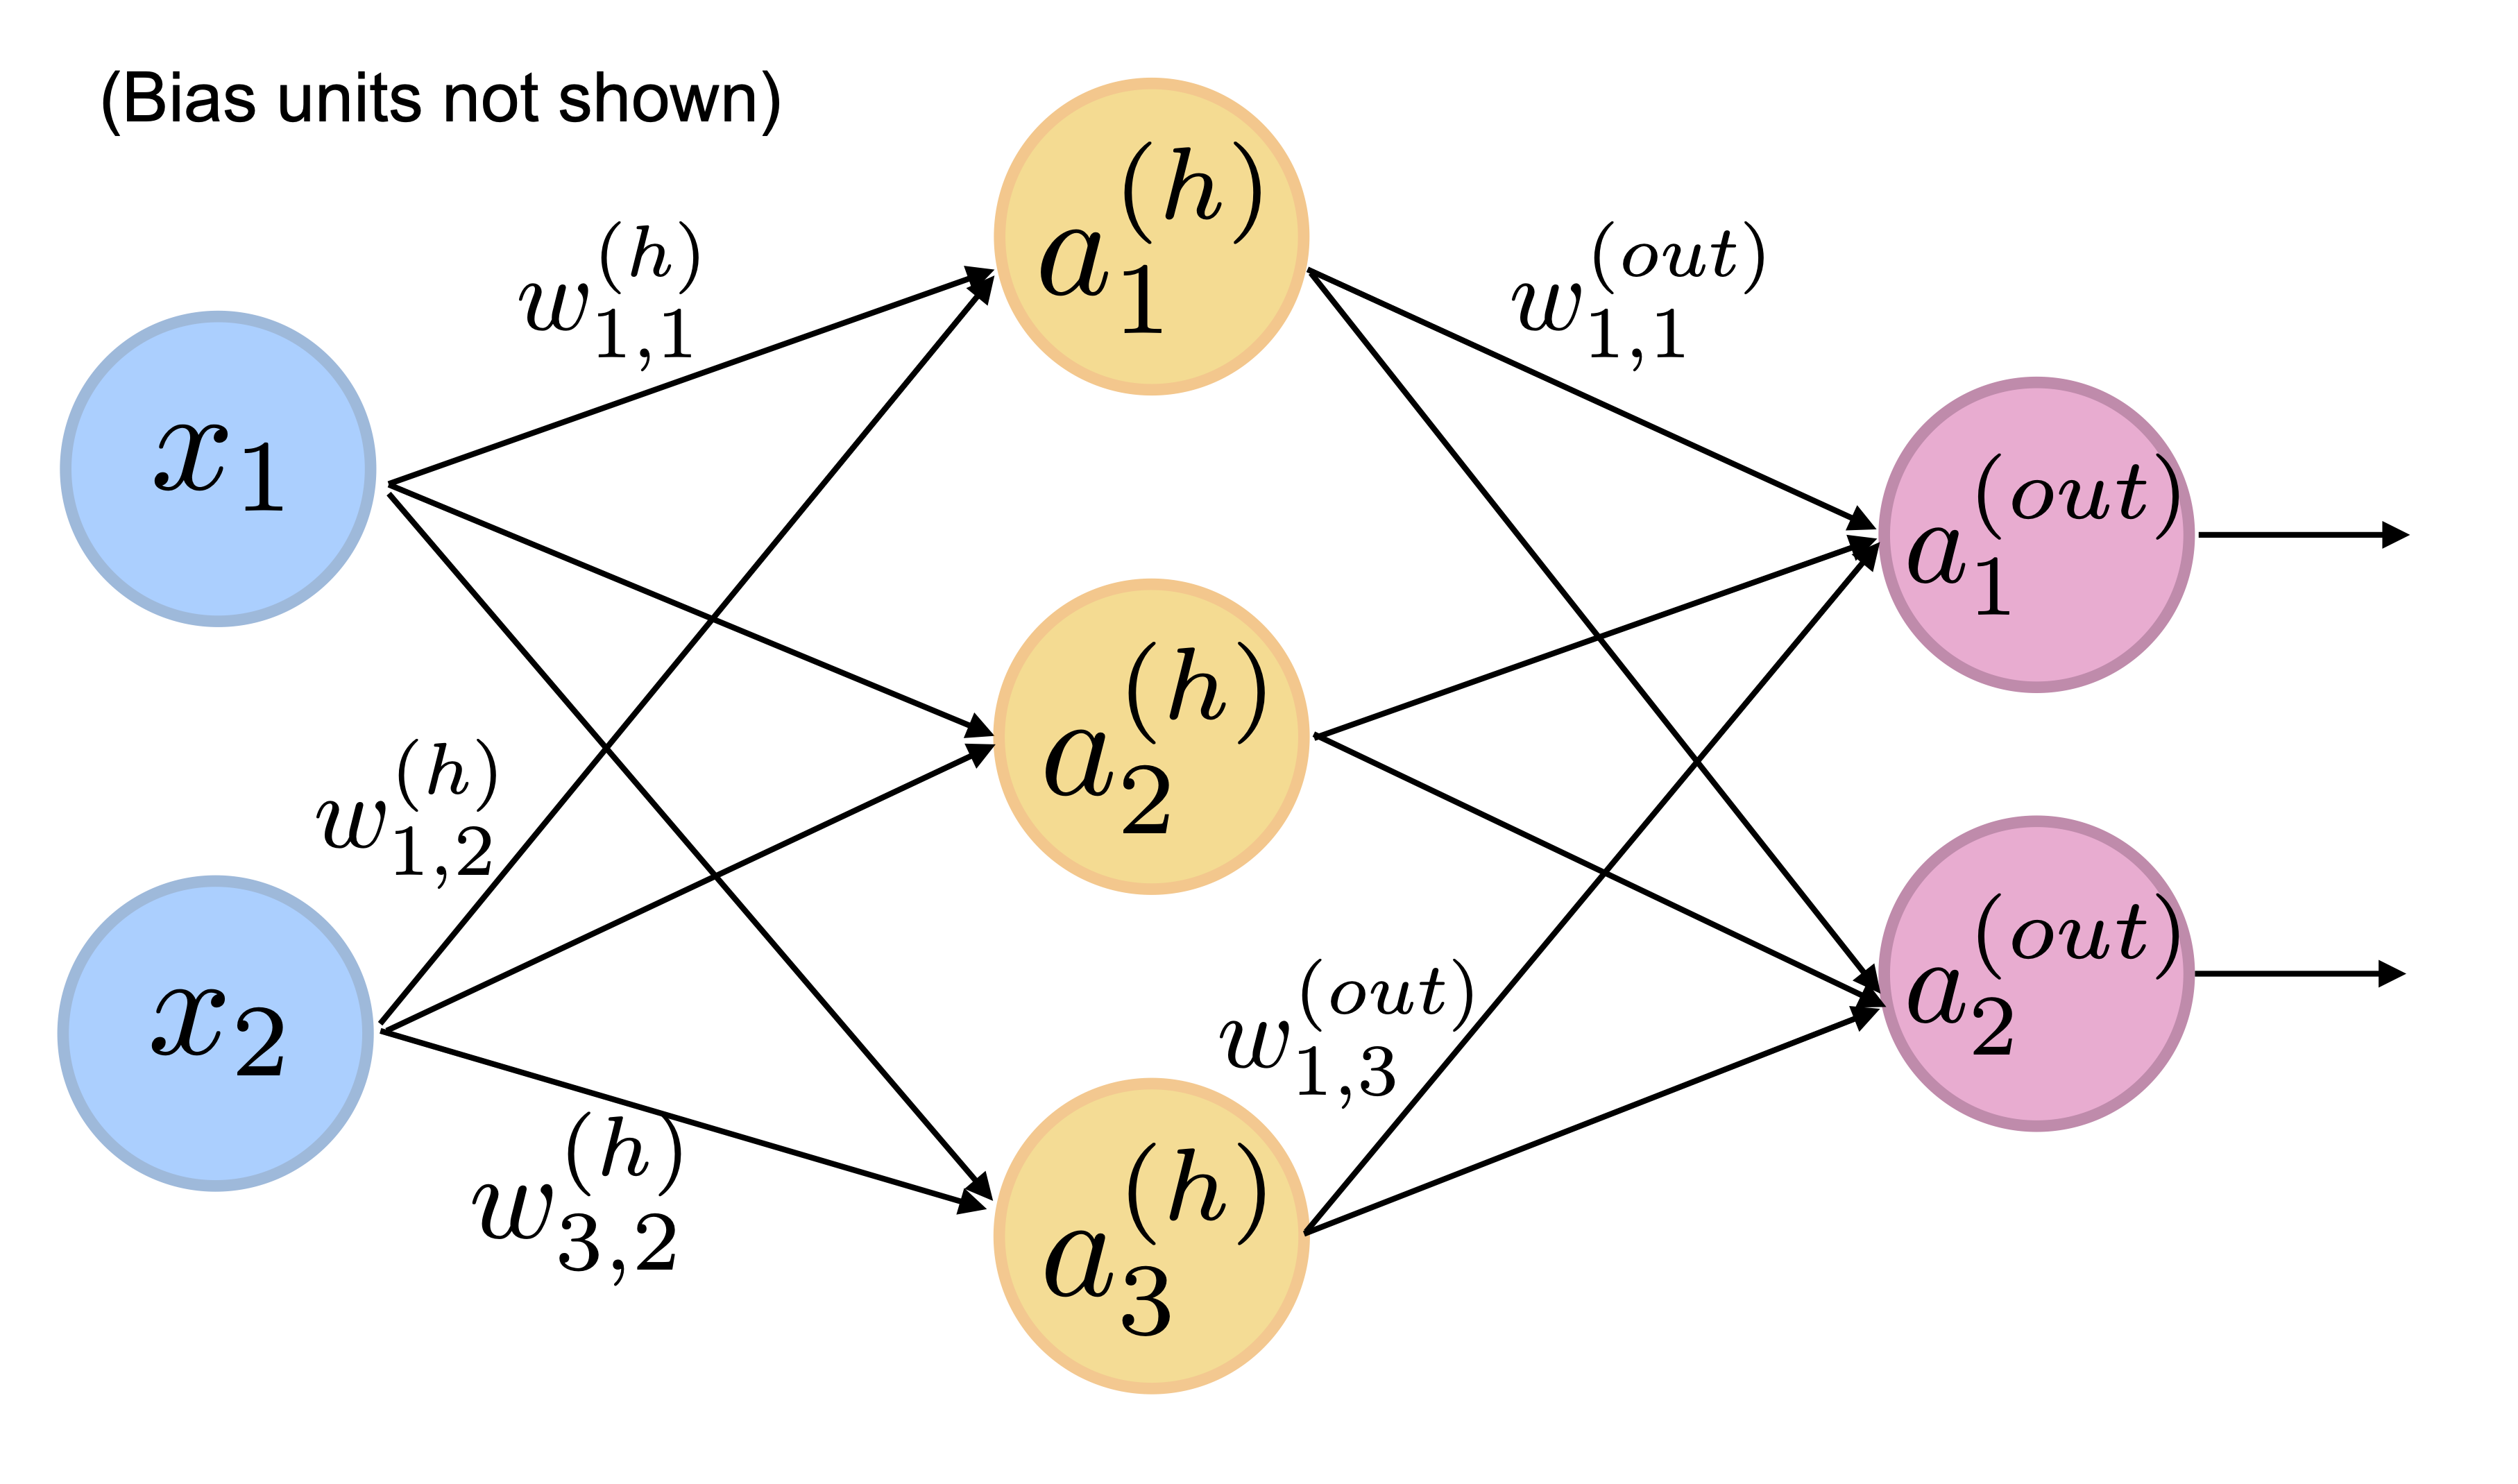

In [27]:
Image(filename='./figures/11_11.png', width=400) 

In the above, we have two input features, three hidden node, and two output nodes.

In backpropagation, we propagate the error from right to left. We can think of this as an application of the chain rule to the computation of the forward pass to compute the gradient of the loss with respect to the model weights (and bias units). For simplicity, we illustrate this process for the partial derivative used to update the first weight in the weight matrix of the output layer.

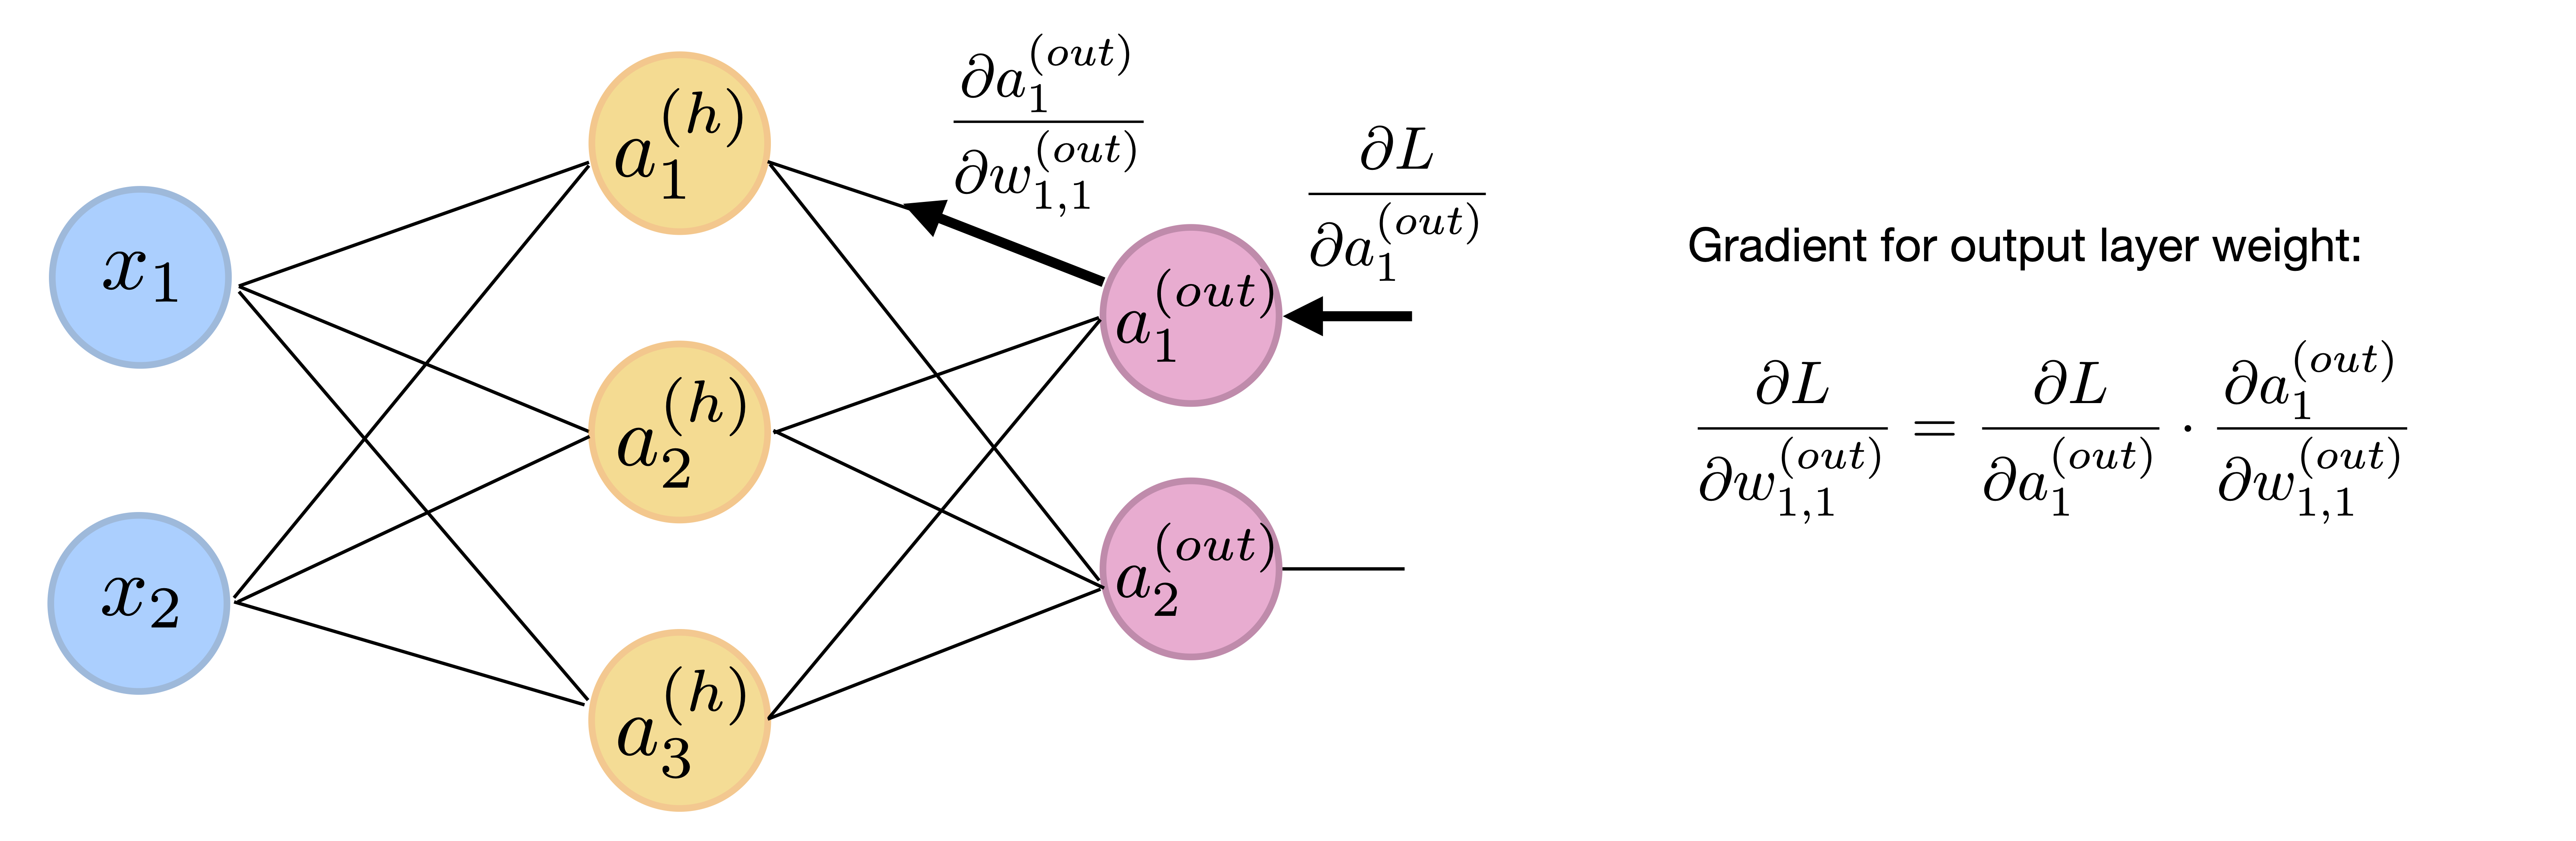

In [28]:
Image(filename='figures/11_12.png', width=500) 

If we include the net inputs $z$ explicitly, the partial derivative computation shown in the previous figure expands as follows:
\begin{align}
\frac{\partial L}{\partial w^{(out)}_{1,1}} = \frac{\partial L}{\partial a^{(out)}_{1}} \cdot \frac{\partial a^{(out)}_{1}}{\partial z^{(out)}_1} \cdot \frac{\partial z^{(out)}_1}{\partial w^{(out)}_{1,1}}. 
\end{align}

To compute this partial derivative, which is used to update $w^{(out)}_{1,1}$, we can compute the three individual partial derivative terms and multiply the results. For simplicity, we omit averaging over the individual examples in the mini-batch, so we drop the $\frac{1}{n}\sum^n_{i=1}$ averaging term from the following equations.

- Term 1: $\frac{\partial L}{\partial a^{(out)}_{1}} = \frac{\partial }{\partial a^{(out)}_{1}}(y_1 -a^{(out)}_{1})^2 = 2 (a^{(out)}_{1} - y_1).$
- Term 2:  $\frac{\partial a^{(out)}_{1}}{\partial z^{(out)}_1} = \frac{\partial }{\partial z^{(out)}_{1}} \frac{1}{1+e^{z^{(out)}_1}} = \left(\frac{1}{1+e^{z^{(out)}_1}}\right) \left(1-\frac{1}{1+e^{z^{(out)}_1}}\right) = a^{(out)}_{1}(1-a^{(out)}_{1}).$
- Term 3: $\frac{\partial z^{(out)}_1}{\partial w^{(out)}_{1,1}} = \frac{\partial }{\partial w^{(out)}_{1,1}} \left(a^{(h)}_1 w^{(out)}_{1,1} + b^{(out)}_1\right) = a^{(h)}_1 .$

Thus, $\frac{\partial L}{\partial w^{(out)}_{1,1}} = 2 (a^{(out)}_{1} - y_1) \cdot a^{(out)}_{1}(1-a^{(out)}_{1}) \cdot a^{(h)}_1.$

We then update $w^{(out)}_{1,1}$ using the familiar gradient descent update with learning rate $\eta$:
\begin{align}
w^{(out)}_{1,1} = w^{(out)}_{1,1} - \eta \frac{\partial L}{\partial w^{(out)}_{1,1}}.
\end{align}

Next, we look at the weight updates for the hidden layer unit. The following figure illustrates how to compute the partial derivative of the loss with respect to the first weight of the hidden layer.

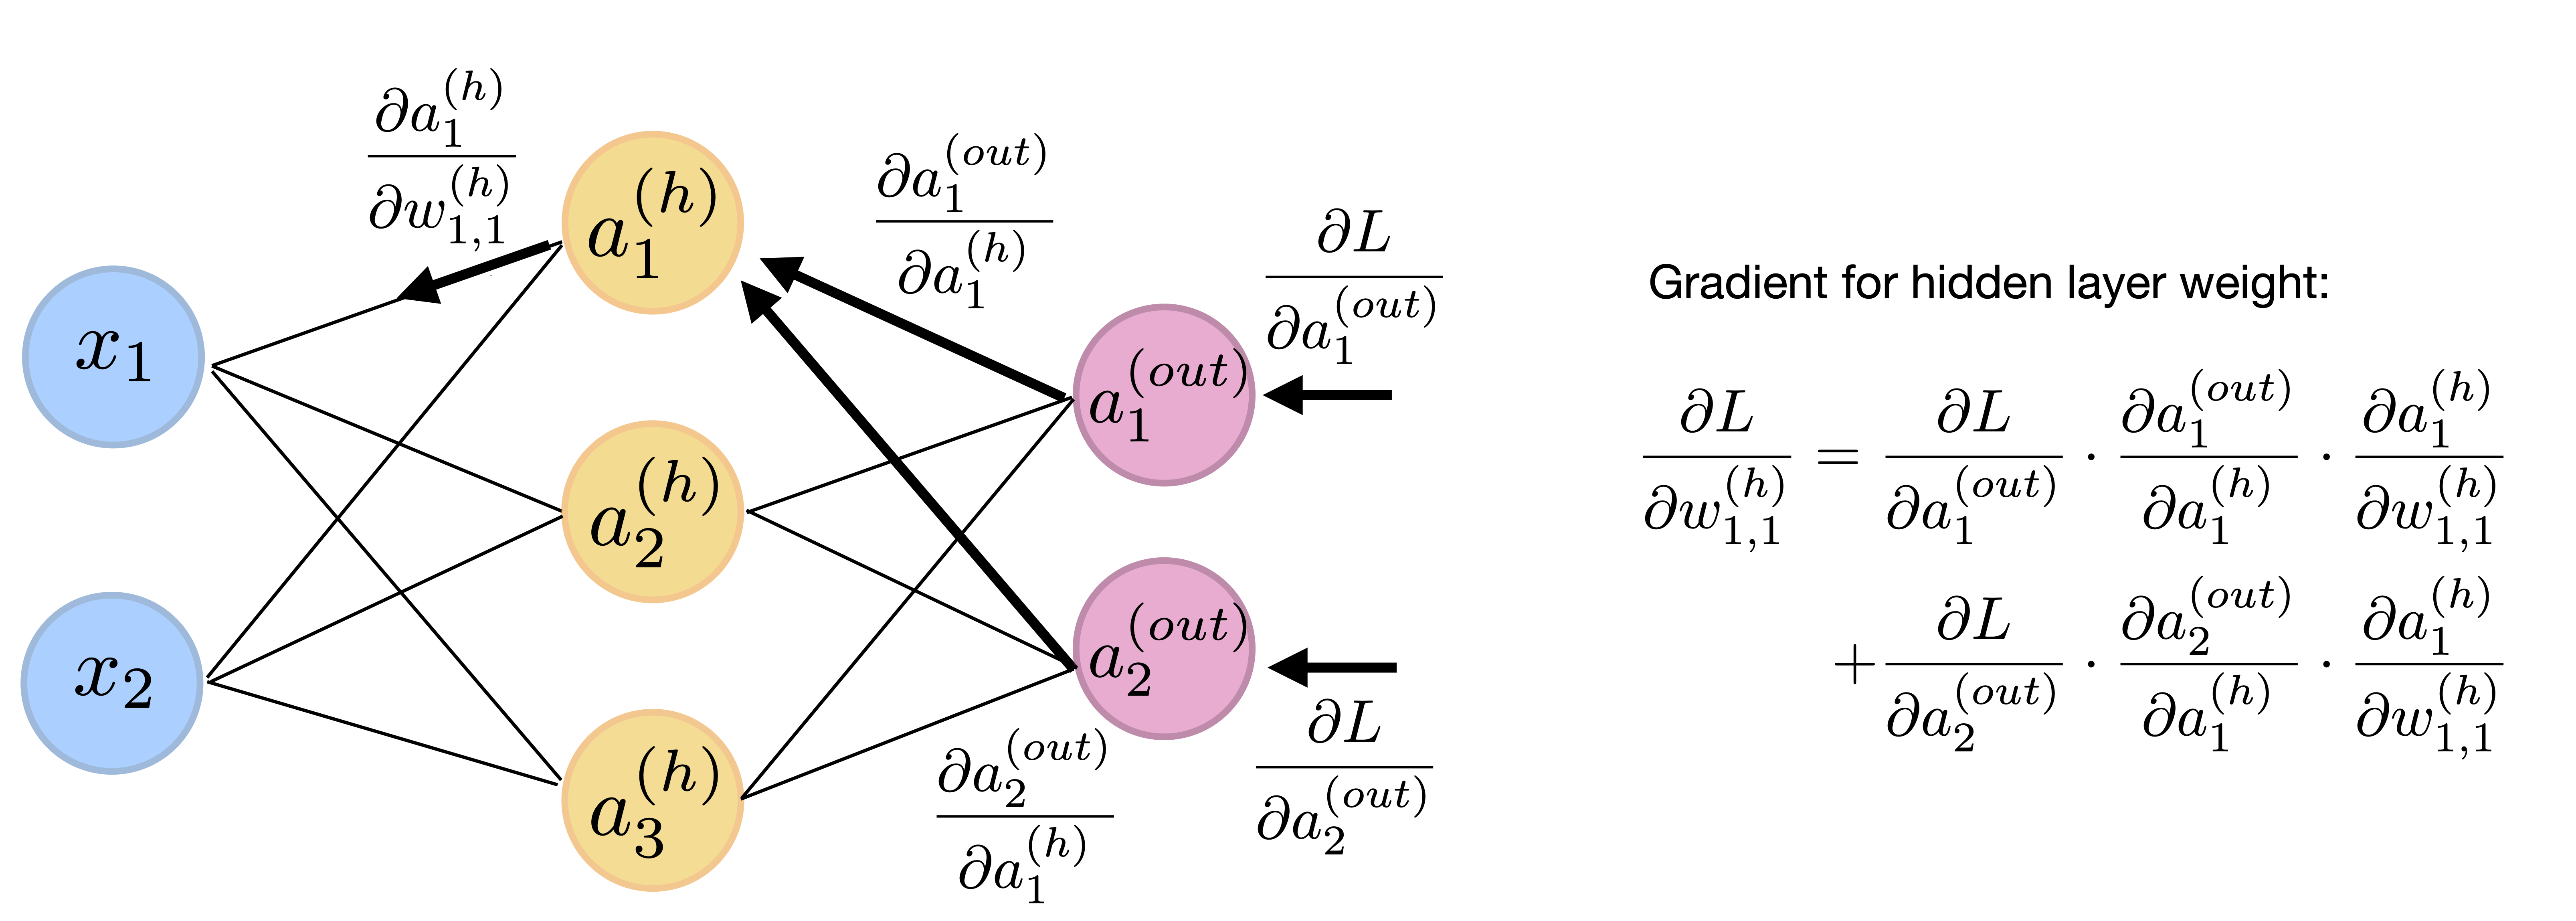

In [29]:
Image(filename='figures/11_13.png', width=500) 

It is important to highlight that since the weight $w^{(h)}_{1,1}$ is connected to both output nodes, we have to use the multi-variable chain rule to sum the two paths highlighted with bold arrows. As before, we can expand it to include the net inputs $z$ and then solve the individual terms:

\begin{align}
\frac{\partial L}{\partial w^{(h)}_{1,1}} &= \frac{\partial L}{\partial a^{(out)}_{1}} \cdot \frac{\partial a^{(out)}_{1}}{\partial z^{(out)}_1} \cdot \frac{\partial z^{(out)}_1}{\partial a^{(h)}_{1}}\cdot \frac{\partial a^{(h)}_{1}}{\partial z^{(h)}_{1}}\cdot \frac{\partial z^{(h)}_{1}}{\partial w^{(h)}_{1,1}}\\
&+ \frac{\partial L}{\partial a^{(out)}_{2}} \cdot \frac{\partial a^{(out)}_{2}}{\partial z^{(out)}_2} \cdot \frac{\partial z^{(out)}_2}{\partial a^{(h)}_{1}}\cdot \frac{\partial a^{(h)}_{1}}{\partial z^{(h)}_{1}}\cdot \frac{\partial z^{(h)}_{1}}{\partial w^{(h)}_{1,1}}.
\end{align}

Note that in the above, we would have already computed $\frac{\partial L}{\partial a^{(out)}_{1}} \cdot \frac{\partial a^{(out)}_{1}}{\partial z^{(out)}_1}$ and $\frac{\partial L}{\partial a^{(out)}_{2}} \cdot \frac{\partial a^{(out)}_{2}}{\partial z^{(out)}_2}$ in the preceding step of the backpropagation algorithm. The other terms can be found easily too.

# Convergence in neural networks

Multilayer NNs are much harder to train than simpler algorithms such as Adaline, logistic regression, or support vector machines. In multilayer NNs, we typically have hundreds, thousands, or even billions of weights that we need to optimize. Unfortunately, the output function has a rough surface, and the optimization algorithm can easily become trapped in local minima.

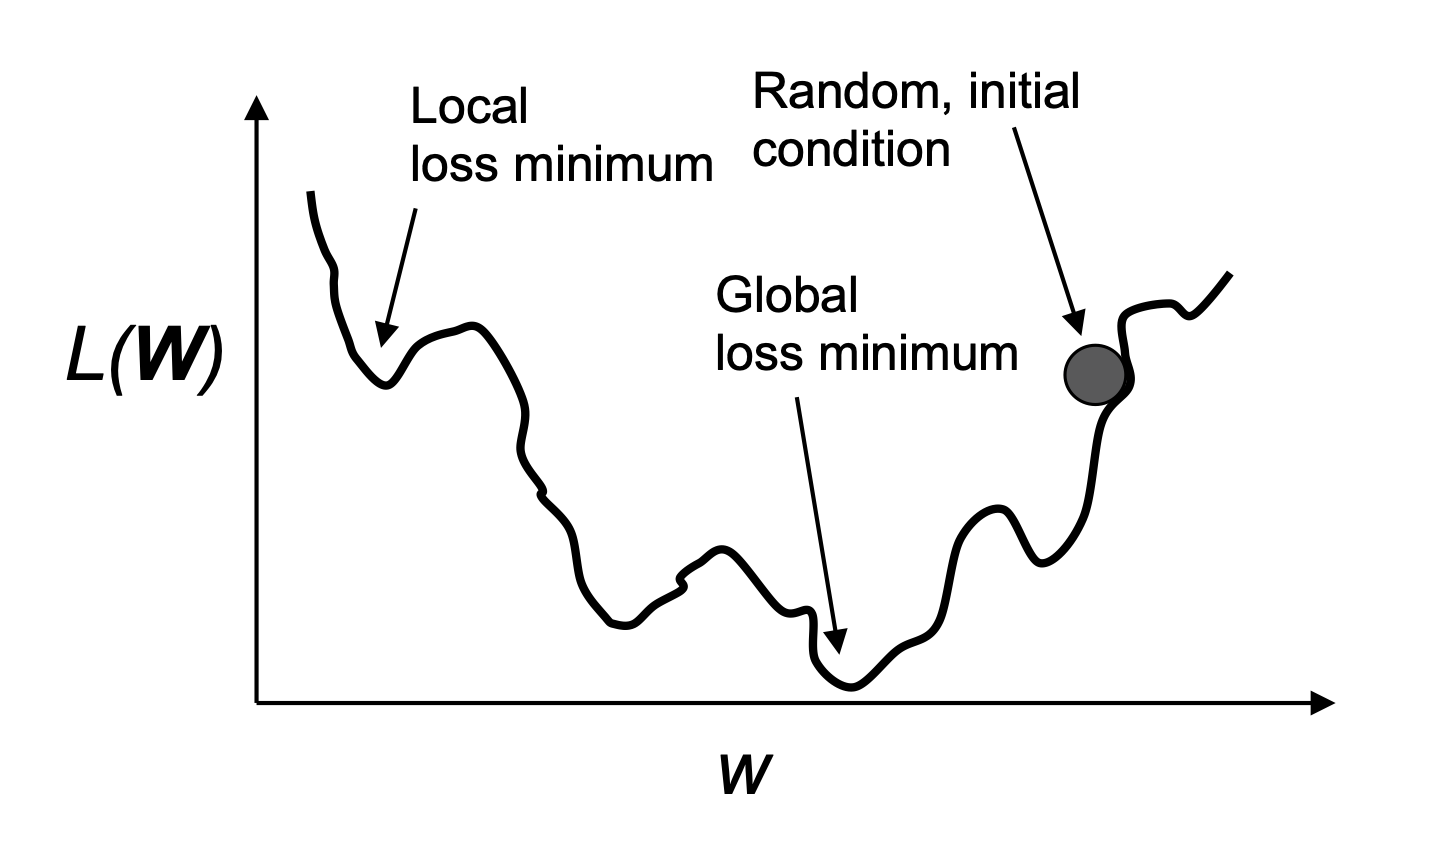

In [30]:
Image(filename='figures/11_14.png', width=500) 

By increasing the learning rate, we can more readily escape such local minima. On the other hand, we also increase the chance of overshooting the global optimum if the learning rate is too large. Since we initialize the weights randomly, we start with a solution to the optimization problem that is typically hopelessly wrong. As a result, for training NNs, we always use mini-batch learning instead of the regular gradient descent.